# Responsible AI: XAI GenAI project

## 0. Background



Based on the previous lessons on explainability, post-hoc methods are used to explain the model, such as saliency map, SmoothGrad, LRP, LIME, and SHAP. Take LRP (Layer Wise Relevance Propagation) as an example; it highlights the most relevant pixels to obtain a prediction of the class "cat" by backpropagating the relevance. (image source: [Montavon et. al (2016)](https://giorgiomorales.github.io/Layer-wise-Relevance-Propagation-in-Pytorch/))

<!-- %%[markdown] -->
![LRP example](images/catLRP.jpg)

Another example is about text sentiment classification, here we show a case of visualizing the importance of words given the prediction of 'positive':

![text example](images/textGradL2.png)

where the words highlight with darker colours indicate to be more critical in predicting the sentence to be 'positive' in sentiment.
More examples could be found [here](http://34.160.227.66/?models=sst2-tiny&dataset=sst_dev&hidden_modules=Explanations_Attention&layout=default).

Both cases above require the class or the prediction of the model. But:

***How do you explain a model that does not predict but generates?***

In this project, we will work on explaining the generative model based on the dependency between words. We will first look at a simple example, and using Point-wise Mutual Information (PMI) to compute the saliency map of the sentence. After that we will contruct the expereiment step by step, followed by exercises and questions.


## 1. A simple example to start with
Given a sample sentence: 
> *Tokyo is the capital city of Japan.* 

We are going to explain this sentence by finding the dependency using a saliency map between words.
The dependency of two words in the sentence could be measured by [Point-wise mutual information (PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information): 


Mask two words out, e.g. 
> \[MASK-1\] is the captial city of \[MASK-2\].


Ask the generative model to fill in the sentence 10 times, and we have:

| MASK-1      | MASK-2 |
| ----------- | ----------- |
|    tokyo   |     japan   |
|  paris  |     france    |
|  london  |     england    |
|  paris  |     france    |
|  beijing |  china |
|    tokyo   |     japan   |
|  paris  |     france    |
|  paris  |     france    |
|  london  |     england    |
|  beijing |  china |

PMI is calculated by: 

$PMI(x,y)=log_2⁡ \frac{p(\{x,y\}| s-\{x,y\})}{P(\{x\}|s-\{x,y\})P(\{y\}|s-\{x,y\})}$

where $x$, $y$ represents the words that we masked out, $s$ represents the setence, and $s-\{x,y\}$ represents the sentences tokens after removing the words $x$ and $y$.

In this example we have $PMI(Tokyo, capital) = log_2 \frac{0.2}{0.2 * 0.2} = 2.32$

Select an interesting word in the sentences; we can now compute the PMI between all other words and the chosen word using the generative model:
(Here, we use a longer sentence and run 20 responses per word.)
![](images/resPMI.png)


## 2. Preparation
### 2.1 Conda enviroment

```
conda env create -f environment.yml
conda activate xai_llm
```


### 2.2 Download the offline LLM

We use the offline LLM model from hugging face. It's approximately 5 GB.
Download it using the comman below, and save it under `./models/`.
```
huggingface-cli download TheBloke/openchat-3.5-0106-GGUF openchat-3.5-0106.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False
# credit to https://huggingface.co/TheBloke/openchat-3.5-0106-GGUF
```

## 3. Mask the sentence and get the responses from LLM
### 3.1 Get the input sentence

**Remember to change the anchor word index when changing the input sentence.**

In [1]:
anchor_word_idx = 0 # the index of the interested word
prompts_per_word = 20 # number of generated responses  

sentence ="Tokyo is the capital of Japan"
sentence = sentence.lower()
print("Sentence: ", sentence)

Sentence:  tokyo is the capital of japan


### 3.2 Load the model

In [2]:
from models.ChatModel import ChatModel
model_name = "openchat"
model = ChatModel(model_name)
print(f"Model: {model_name}")

Model: openchat


### 3.3 Run the prompts and get all the responses


In [3]:
import os
import json
from tools.command_generator import generate_prompts, prefix_prompt
from tools.evaluate_response import get_replacements
from tqdm import tqdm

# Add cache logic for faster testing. Althought model is not returning the same results for the same prompt, I added it becouse of slow model response time.
CACHE_DIR = "cache"

def load_cache(file_name):
    """Load cached results from a file."""
    if os.path.exists(file_name):
        with open(file_name, "r") as file:
            return json.load(file)
    return None

def save_cache(file_name, data):
    """Save results to a cache file."""
    with open(file_name, "w") as file:
        json.dump(data, file)

def run_prompts(model, sentence, anchor_idx, prompts_per_word=20):
    if not os.path.exists(CACHE_DIR):
        os.makedirs(CACHE_DIR)

    cache_file = os.path.join(
        CACHE_DIR, f"responses_{sentence.replace(' ', '_')}_idx{anchor_idx}_words{prompts_per_word}.json"
    )

    cached_results = load_cache(cache_file)
    if cached_results is not None:
        print(f"Loaded cached results from {cache_file}")
        return cached_results

    prompts = generate_prompts(sentence, anchor_idx)
    all_replacements = []
    for prompt in prompts:
        replacements = []
        for _ in tqdm(
            range(prompts_per_word),
            desc=f"Input: {prompt}",
        ):
            response = model.get_response(
                prefix_prompt(prompt),
            ).strip()
            if response:
                replacement = get_replacements(prompt, response)
                if replacement:
                    replacements.append(tuple(replacement))
        if len(replacements) > 0:
            all_replacements.append(replacements)

    # Save results to cache
    save_cache(cache_file, all_replacements)
    print(f"Results saved to cache: {cache_file}")

    return all_replacements

all_responses = run_prompts(model, sentence, anchor_word_idx, prompts_per_word)

Loaded cached results from cache/responses_tokyo_is_the_capital_of_japan_idx0_words20.json


### 3.4 EXERCISE: compute the PMI for each word

$PMI(x,y)=log_2⁡ \frac{p(\{x,y\}| s-\{x,y\})}{P(\{x\}|s-\{x,y\})P(\{y\}|s-\{x,y\})}$

* Compute the $P(x)$, $P(y)$ and $P(x,y)$ first and print it out.
* Compute the PMI for each word.
* Visualize the result by coloring. Tips: you might need to normalize the result first. 


In [4]:
import pandas as pd
from IPython.display import display, Markdown

def visualize_replacements(all_responses, sentence, anchor_word_idx):
    prompts = generate_prompts(sentence, anchor_word_idx)
    for i, replacements in enumerate(all_responses):
        prompt = prompts[i]
        data = []
        
        for j, replacement in enumerate(replacements):
            filled_prompt = prompt.replace("[MASK]", replacement[0], 1).replace("[MASK]", replacement[1], 1)
            data.append({
                "No.": j + 1,  # Add numbering for replacements
                "Filled Prompt": filled_prompt,
                "Replacements": f"({replacement[0]}, {replacement[1]})"
            })
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Display prompt with Markdown
        display(Markdown(f"### Prompt: `{prompt}`"))
        
        styled_df = df.style.hide(axis="index")
        display(styled_df)
        print("\n")  # Add spacing between prompts for better separation



visualize_replacements(all_responses, sentence, anchor_word_idx)

### Prompt: `[MASK] [MASK] the capital of japan`

No.,Filled Prompt,Replacements
1,the capital of japan,"(, )"
2,tokyo is the capital of japan,"(tokyo, is)"
3,tokyo is the capital of japan,"(tokyo, is)"
4,the capital of japan,"(, )"
5,tokyo is the capital of japan,"(tokyo, is)"
6,the capital of japan,"(, )"
7,tokyo is the capital of japan,"(tokyo, is)"
8,the capital of japan,"(, )"
9,tokyo is the capital of japan,"(tokyo, is)"
10,tokyo is the capital of japan,"(tokyo, is)"


### Prompt: `[MASK] is [MASK] capital of japan`

No.,Filled Prompt,Replacements
1,is capital of japan,"(, )"
2,is capital of japan,"(, )"
3,tokyo is the capital of japan,"(tokyo, the)"
4,tokyo is the capital of japan,"(tokyo, the)"
5,tokyo is the capital of japan,"(tokyo, the)"
6,is capital of japan,"(, )"
7,is capital of japan,"(, )"
8,tokyo is the capital of japan,"(tokyo, the)"
9,is capital of japan,"(, )"
10,tokyo is the capital of japan,"(tokyo, the)"


### Prompt: `[MASK] is the [MASK] of japan`

No.,Filled Prompt,Replacements
1,flix is the capital of japan,"(flix, capital)"
2,tokyo is the capital of japan,"(tokyo, capital)"
3,tokyo is the capital of japan,"(tokyo, capital)"
4,the city of tokyo is the capital of japan,"(the city of tokyo, capital)"
5,tokyo is the capital of japan,"(tokyo, capital)"
6,tokyo is the capital of japan,"(tokyo, capital)"
7,tokyo is the capital of japan,"(tokyo, capital)"
8,the word to replace is the be capital so the sentence would read tokyo is the capital of japan,"(the word to replace, be capital so the sentence would read tokyo is the capital)"
9,tokyo is the capital of japan,"(tokyo, capital)"
10,tokyo is the capital of japan,"(tokyo, capital)"


### Prompt: `[MASK] is the capital [MASK] japan`

No.,Filled Prompt,Replacements
1,is the capital japan,"(, )"
2,tokyo is the capital of japan,"(tokyo, of)"
3,tokyo is the capital of japan,"(tokyo, of)"
4,tokyo is the capital [mask] japan,"(tokyo, [mask])"
5,tokyo is the capital of japan,"(tokyo, of)"
6,tokyo is the capital of japan,"(tokyo, of)"
7,tokyo is the capital of japan,"(tokyo, of)"
8,tokyo is the capital of japan,"(tokyo, of)"
9,tokyo is the capital of japan,"(tokyo, of)"
10,tokyo is the capital city of japan,"(tokyo, city of)"


### Prompt: `[MASK] is the capital of [MASK]`

No.,Filled Prompt,Replacements
1,kehran is the capital of estonia,"(kehran, estonia)"
2,paris is the capital of france,"(paris, france)"
3,paris is the capital of france,"(paris, france)"
4,tokyo is the capital of japan,"(tokyo, japan)"
5,paris is the capital of france,"(paris, france)"
6,madrid is the capital of spain,"(madrid, spain)"
7,paris is the capital of france,"(paris, france)"
8,paris is the capital of france,"(paris, france)"
9,london is the capital of england,"(london, england)"
10,paris is the capital of france,"(paris, france)"


In [5]:
def strict_similarity(word1, word2):
    return int(word1 == word2)

,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,14/20,13/20,13/20,0.51
2,the,12/20,11/20,11/20,0.74
3,capital,14/20,16/20,14/20,0.32
4,of,19/20,16/20,16/20,0.07
5,japan,3/20,3/20,3/20,2.74


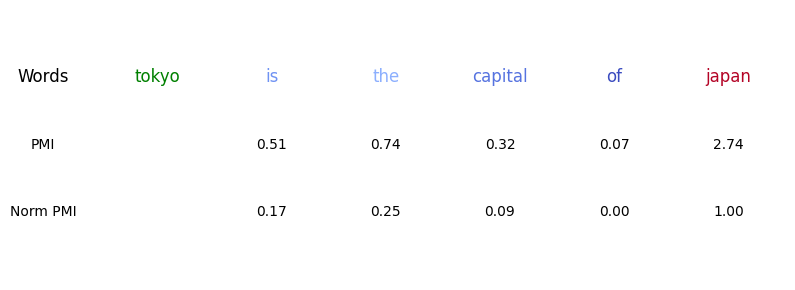

In [6]:
import numpy as np
from collections import Counter


import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import display, Markdown


from typing import Callable

def calculate_pmi(sentence, anchor_word_idx, all_responses, similarity_function: Callable[[str, str, object], int] = None, debug=False):
    words = sentence.split()
    anchor_word = words[anchor_word_idx]
    pmi_list = []
    if similarity_function is None:
        similarity_function = strict_similarity
    if debug:
        debug_data = [] 
    response_index = 0
    for word_index, word in enumerate(words):
        if word_index != anchor_word_idx:
            if anchor_word_idx < word_index:
                x_word, y_word = anchor_word, word
            else:
                x_word, y_word = word, anchor_word
            
            sum_of_X_similaritties = np.sum([similarity_function(x_word, response[0]) for response in all_responses[response_index]])
            sum_of_Y_similaritties = np.sum([similarity_function(y_word, response[1]) for response in all_responses[response_index]])
            sum_of_XY_similaritties = np.sum([similarity_function(x_word, response[0]) * similarity_function(y_word, response[1]) for response in all_responses[response_index]])
                
            
            total = len(all_responses[response_index])
            p_x = sum_of_X_similaritties / total
            p_y = sum_of_Y_similaritties / total
            p_xy = sum_of_XY_similaritties / total
            epsilon = 1e-10
            pmi = np.log2((p_xy+epsilon) / (p_x * p_y + epsilon))
            pmi_list.append(pmi)
            response_index += 1
            if debug:
                debug_data.append({
                    "Word": word,
                    f"P({{x}}|s - {{x, y}})": f"{str(round(sum_of_X_similaritties, 2))}/{total}",
                    f"P({{y}}|s - {{x, y}})": f"{str(round(sum_of_Y_similaritties, 2))}/{total}",
                    f"P({{x, y}}|s - {{x, y}})": f"{str(round(sum_of_XY_similaritties, 2))}/{total}",
                    "PMI": round(pmi, 2)
                })
        else:
            pmi_list.append(0)
            if debug:
                debug_data.append({
                    "Word": word,
                    f"P({{x}}|s - {{x, y}})": "N/A",
                    f"P({{y}}|s - {{x, y}})": "N/A",
                    f"P({{x, y}}|s - {{x, y}})": "N/A",
                    "PMI": 0
                })
    
    if debug:
        debug_df = pd.DataFrame(debug_data)
        display(debug_df)
    
    return pmi_list



import matplotlib.pyplot as plt
import numpy as np

def visualize_pmi(pmi_list, sentence, anchor_word_idx, max_words_per_line=10):
    words = sentence.split()
    pmi_values = np.array(pmi_list)

    # Normalize the PMI values
    norm = plt.Normalize(pmi_values[np.arange(len(pmi_values)) != anchor_word_idx].min(),
                         pmi_values[np.arange(len(pmi_values)) != anchor_word_idx].max())
    norm_pmi_values = norm(pmi_values)

    # Create a color map
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm_pmi_values)

    # Split words into multiple lines for long sentences
    num_lines = (len(words) + max_words_per_line - 1) // max_words_per_line
    fig, axes = plt.subplots(num_lines, 1, figsize=(0.8 * max_words_per_line, 3 * num_lines))

    if num_lines == 1:
        axes = [axes]  # Ensure axes is always a list for consistency

    for line_idx, ax in enumerate(axes):
        start_idx = line_idx * max_words_per_line
        end_idx = min((line_idx + 1) * max_words_per_line, len(words))

        for i, word_idx in enumerate(range(start_idx, end_idx)):
            word = words[word_idx]
            color = 'green' if word_idx == anchor_word_idx else colors[word_idx]

            ax.text(i, 1, word, fontsize=12, ha='center', va='center',
                    color=color)

            if word_idx != anchor_word_idx:
                # PMI and normalized PMI below each word
                ax.text(i, 0.5, f"{pmi_values[word_idx]:.2f}", fontsize=10, ha='center', va='center', color='black')
                ax.text(i, 0, f"{norm_pmi_values[word_idx]:.2f}", fontsize=10, ha='center', va='center', color='black')

        # Adjust axis for the current line
        ax.set_xlim(-0.5, end_idx - start_idx - 0.5)
        ax.set_ylim(-0.5, 1.5)
        ax.axis('off')

        # Add headers for the first line
        if line_idx == 0:
            ax.text(-1, 1, "Words", fontsize=12, ha='center', va='center', color='black')
            ax.text(-1, 0.5, "PMI", fontsize=10, ha='center', va='center', color='black')
            ax.text(-1, 0, "Norm PMI", fontsize=10, ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

pmi_list = calculate_pmi(sentence, anchor_word_idx, all_responses, debug=True)
visualize_pmi(pmi_list, sentence, anchor_word_idx)


## 4. EXERCISE: Try more examples; maybe come up with your own. Report the results.

* Try to come up with more examples and, change the anchor word/number of responses, and observe the results

In [7]:
def make_expermient(sentence, anchor_word_idx, prompts_per_word, model: ChatModel, similarity_function= None, debug=False):
    sentence = sentence.lower()
    all_responses = run_prompts(model, sentence, anchor_word_idx, prompts_per_word)
    if debug:
        # clean jupyter notebook output
        from IPython.display import clear_output
        clear_output()
        visualize_replacements(all_responses, sentence, anchor_word_idx)
    pmi_list = calculate_pmi(sentence, anchor_word_idx, all_responses,similarity_function, debug=True)
    visualize_pmi(pmi_list, sentence, anchor_word_idx)


> NOTE: The experiment will be conducted with a maximum of 20 prompts per word due to limited computational power.

### Compering PMI when we change the word order

Loaded cached results from cache/responses_tokyo_is_the_capital_of_japan_idx0_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,14/20,13/20,13/20,0.51
2,the,12/20,11/20,11/20,0.74
3,capital,14/20,16/20,14/20,0.32
4,of,19/20,16/20,16/20,0.07
5,japan,3/20,3/20,3/20,2.74


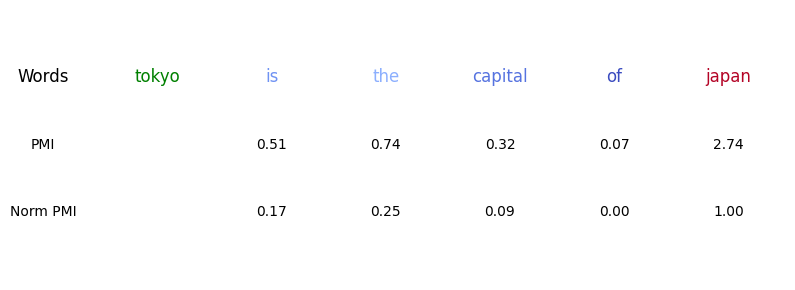

In [8]:
## Orginal word order with Tokyo as anchor word
make_expermient("Tokyo is the capital of Japan", 0, 20, model)

Loaded cached results from cache/responses_the_capital_of_japan_is_tokyo_idx5_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,the,2/20,2/20,2/20,3.32
1,capital,8/20,8/20,8/20,1.32
2,of,14/20,18/20,14/20,0.15
3,japan,2/20,3/20,2/20,2.74
4,is,17/20,9/20,9/20,0.23
5,tokyo,N/A,N/A,N/A,0.00


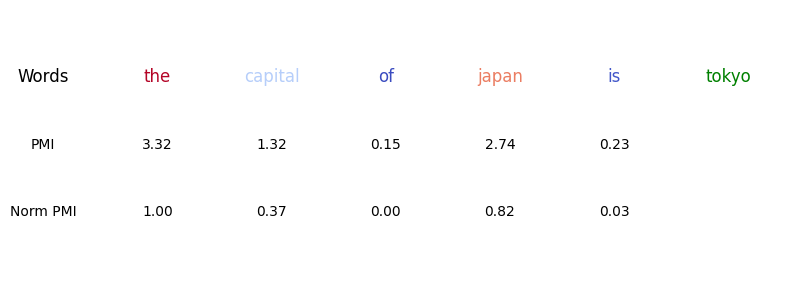

In [9]:
# Reversed word order with Tokyo as anchor word
make_expermient("The capital of Japan is Tokyo", 5, 20, model)

#### Conclusion
> Changing the word order changes the PMI scores. Although Japan is still strongly "correlated" with Tokyo, we can see a big difference in words like "The" and "capital." This is most probably because of the small number of prompts per word, as even one example can greatly affect the score. On the other hand, it could be connected to the model architecture.

### Calculating PMI for hard word

Loaded cached results from cache/responses_the_bank_by_the_river_is_closed_idx1_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,the,9/20,0/20,0/20,0.00
1,bank,N/A,N/A,N/A,0.00
2,by,0/20,0/20,0/20,0.00
3,the,0/20,1/20,0/20,0.00
4,river,3/20,5/20,0/20,-28.48
5,is,0/20,1/20,0/20,0.00
6,closed,3/20,0/20,0/20,0.00


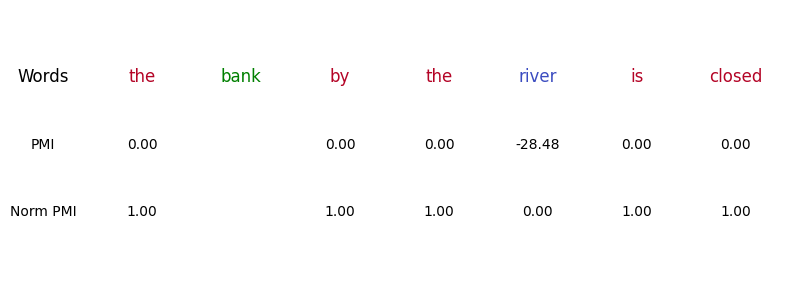

In [10]:
make_expermient("The bank by the river is closed", 1, 20, model)

#### Conclusion
> We can see that when choosing hard-to-guess words, the score does not provide useful information.

### Calculeting PMI for long sentence.

Loaded cached results from cache/responses_despite_the_storm_the_ship_sailed_toward_its_goal_idx4_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,despite,0/20,6/20,0/20,0.00
1,the,0/20,4/20,0/20,0.00
2,storm,9/20,16/20,8/20,0.15
3,the,1/20,0/20,0/20,0.00
4,ship,N/A,N/A,N/A,0.00
5,sailed,3/20,0/20,0/20,0.00
6,toward,18/20,1/20,1/20,0.15
7,its,13/20,15/20,13/20,0.42
8,goal,15/20,0/20,0/20,0.00


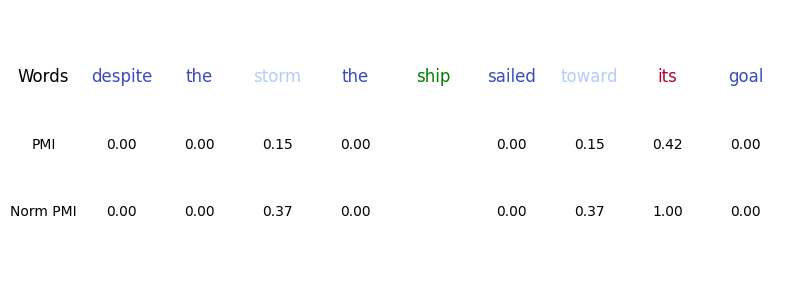

In [11]:
make_expermient("Despite the storm the ship sailed toward its goal", 4, 20, model)

### Conclusion
> The PMI seems to work okay for longer sentences, but here the strict similarity gives words like "goal" a low value (because the model predicts "destination" instead of "goal").

* What does the explanation mean?
> From the equation $PMI(x,y)=log_2⁡ \frac{p(\{x,y\}| s-\{x,y\})}{P(\{x\}|s-\{x,y\})P(\{y\}|s-\{x,y\})}$, we can conclude that the score will be high for two masked words that are both rare but usually occur together.



* Do you think it's a nice explanation? Why and why not?
> The explanation tries to capture the crucial dependencies between generated words, favoring the "nuanced" dependencies and trying to diminish dependencies with obvious pairs like "Subject" and "is". The explanation is nice because it works on proprietary models without access to the model weights, but there are quite a lot of limitations that will be discussed in the next question.


* What's the limitation of the current method? When does the method fail to explain? 
> - First of all, this method will yield consistent results only with a high number of prompts per tested word, which is cost/resources expensive.
> - The choice of prefix prompt will change the experiment results.
> - The chosen model doesn't follow the prefix prompt in many cases and provides more than one word for a mask.
> - For anchor words that are hard to predict based on the provided context, the method will fail to provide useful dependencies between words.


## 5. Bonus Exercises
### 5.1 Language pre-processing. 
In this exercise, we only lower the letters and split sentences into words; there's much more to do to pre-process the language. For example, contractions (*I'll*, *She's*, *world's*), suffix and prefix, compound words (*hard-working*). It's called word tokenization in NLP, and there are some Python packages that can do such work for us, e.g. [*TextBlob*](https://textblob.readthedocs.io/en/dev/). 


### 5.2 Better word matching
In the above example of
> Tokyo is the capital of Japan and a popular metropolis in the world.

, GenAI never gives the specific word 'metropolis' when masking it out; instead, sometimes it provides words like 'city', which is not the same word but has a similar meaning. Instead of measuring the exact matching of certain words (i.e. 0 or 1), we can also measure the similarity of two words, e.g. the cosine similarity in word embedding, which ranges from 0 to 1. 

### Defining the vec similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


def vec_cosine_similarity(model):
    def similarity(word1, word2):
        # Encode words into embeddings
        vec1 = model.encode([word1])
        vec2 = model.encode([word2])
        
        # Compute cosine similarity
        similarity = cosine_similarity(vec1, vec2)[0][0]
        return similarity
    return similarity


embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
cosine_similarity_func = vec_cosine_similarity(embedding_model)

similarity = cosine_similarity_func("city", "metropolis")
print(f"Cosine Similarity for city and metropolis : {similarity}")

similarity = cosine_similarity_func("Denmark", "Poland")
print(f"Cosine Similarity for Denmark, Poland : {similarity}")

similarity = cosine_similarity_func("tokyo", "tokyo")
print(f"Cosine Similarity for tokyo, tokyo : {similarity}")

# example of two words with small similarity
similarity = cosine_similarity_func("tokyo", "poland")
print(f"Cosine Similarity for tokyo, poland : {similarity}")

similarity = cosine_similarity_func("the [mask]", "the")
print(f"Cosine Similarity for the [mask], the : {similarity}")

Cosine Similarity for city and metropolis : 0.6352933049201965
Cosine Similarity for Denmark, Poland : 0.5210166573524475
Cosine Similarity for tokyo, tokyo : 1.0
Cosine Similarity for tokyo, poland : 0.17721477150917053
Cosine Similarity for the [mask], the : 0.42838403582572937


### Testing on the orginal prompt

Loaded cached results from cache/responses_tokyo_is_the_capital_of_japan_idx0_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,14/20,13/20,13/20,0.51
2,the,12/20,11/20,11/20,0.74
3,capital,14/20,16/20,14/20,0.32
4,of,19/20,16/20,16/20,0.07
5,japan,3/20,3/20,3/20,2.74


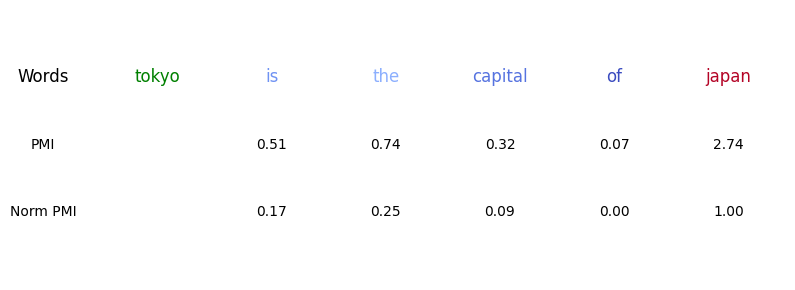

In [13]:
# strict similarity experiment
make_expermient("Tokyo is the capital of Japan", 0, 20, model) 

Loaded cached results from cache/responses_tokyo_is_the_capital_of_japan_idx0_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,15.88/20,17.38/20,14.49/20,0.07
2,the,14.51/20,17.18/20,13.23/20,0.09
3,capital,16.22/20,17.25/20,15.35/20,0.13
4,of,19.31/20,17.31/20,16.87/20,0.01
5,japan,6.92/20,5.39/20,3.61/20,0.95


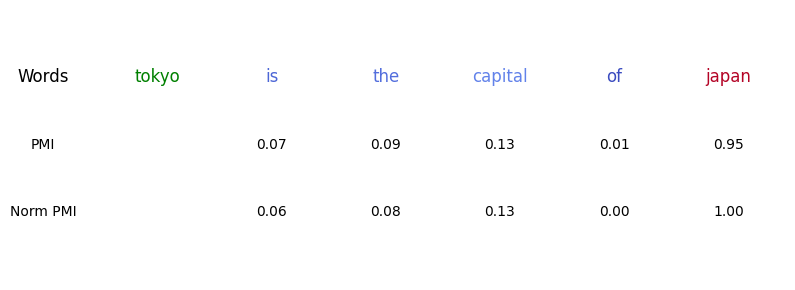

In [14]:
# cosine similarity experiment
make_expermient("Tokyo is the capital of Japan", 0, 20, model, similarity_function=cosine_similarity_func) 

#### Conclusion
> We can see that after applying the cosine similarity, the PMI is more focused on "important" words like capital and Japan, which in my opinion, give a better explanation. 

### Testing diffrences on the provided prompt

Loaded cached results from cache/responses_tokyo_is_the_capital_of_japan_and_a_popular_metropolis_in_the_world._idx0_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,19/20,19/20,18/20,-0.00
2,the,9/20,4/20,4/20,1.15
3,capital,19/20,20/20,19/20,0.00
4,of,16/20,11/20,11/20,0.32
5,japan,14/20,14/20,14/20,0.51
6,and,19/20,5/20,5/20,0.07
7,a,17/20,0/20,0/20,0.00
8,popular,20/20,0/20,0/20,0.00
9,metropolis,19/20,1/20,1/20,0.07


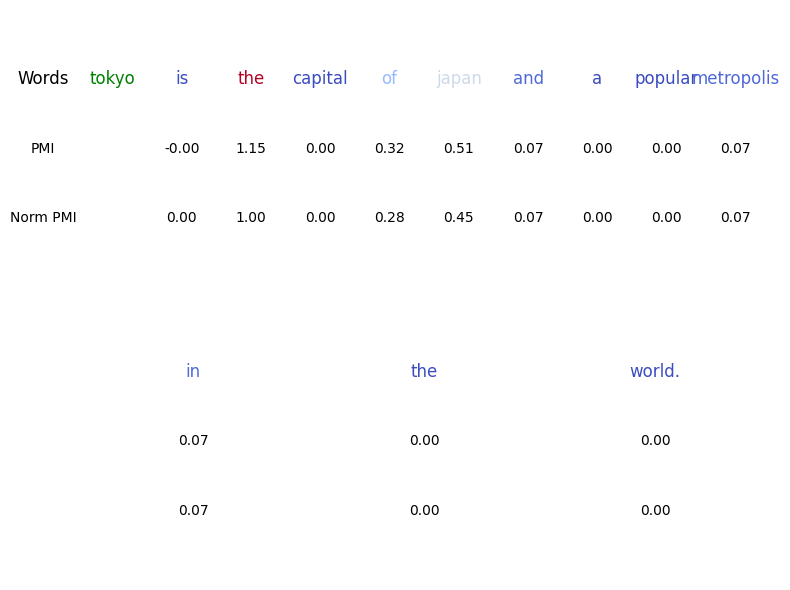

In [15]:
# Strict similarity
make_expermient("Tokyo is the capital of Japan and a popular metropolis in the world.", 0, 20, model)

Loaded cached results from cache/responses_tokyo_is_the_capital_of_japan_and_a_popular_metropolis_in_the_world._idx0_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,19.21/20,19.17/20,18.38/20,-0.00
2,the,12.45/20,13.31/20,7.87/20,-0.07
3,capital,19.25/20,20.0/20,19.25/20,0.00
4,of,17.25/20,15.14/20,13.37/20,0.03
5,japan,15.32/20,14.82/20,14.2/20,0.32
6,and,19.31/20,16.15/20,15.59/20,-0.00
7,a,17.76/20,4.3/20,3.24/20,-0.24
8,popular,20.0/20,7.14/20,7.14/20,0.00
9,metropolis,19.67/20,8.73/20,8.61/20,0.00


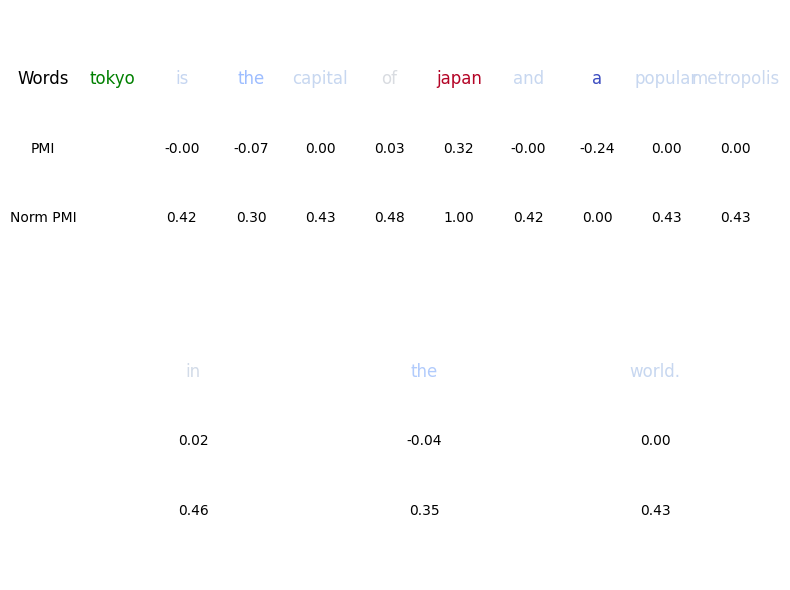

In [16]:
# Cosine similarity
make_expermient("Tokyo is the capital of Japan and a popular metropolis in the world.", 0, 20, model, similarity_function=cosine_similarity_func)

#### Conclusions
> As expected when using the cosine similarity the PMI for nontipical words like "metropolis" is higher than when using the exact match. This is because the model provides words that are similar to the masked word, but not the same.

### The ship experiment

Loaded cached results from cache/responses_despite_the_storm_the_ship_sailed_toward_its_goal_idx4_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,despite,0/20,6/20,0/20,0.00
1,the,0/20,4/20,0/20,0.00
2,storm,9/20,16/20,8/20,0.15
3,the,1/20,0/20,0/20,0.00
4,ship,N/A,N/A,N/A,0.00
5,sailed,3/20,0/20,0/20,0.00
6,toward,18/20,1/20,1/20,0.15
7,its,13/20,15/20,13/20,0.42
8,goal,15/20,0/20,0/20,0.00


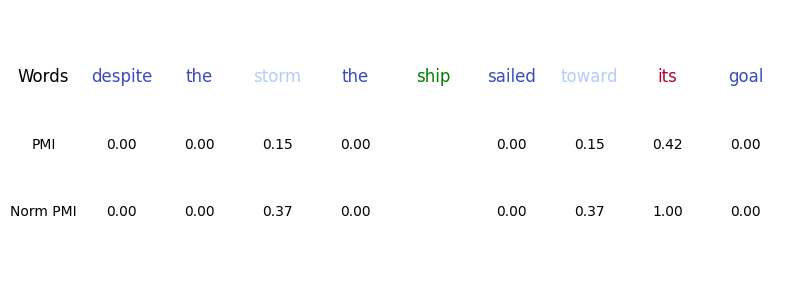

In [17]:
# strict similarity experiment
make_expermient("Despite the storm the ship sailed toward its goal", 4, 20, model)

Loaded cached results from cache/responses_despite_the_storm_the_ship_sailed_toward_its_goal_idx4_words20.json


,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,despite,6.65/20,11.51/20,3.13/20,-0.29
1,the,12.07/20,12.01/20,6.65/20,-0.12
2,storm,14.06/20,18.06/20,13.24/20,0.06
3,the,12.16/20,5.52/20,3.61/20,0.11
4,ship,N/A,N/A,N/A,0.00
5,sailed,7.56/20,8.02/20,3.29/20,0.12
6,toward,19.27/20,14.37/20,13.84/20,-0.00
7,its,16.94/20,18.22/20,16.08/20,0.06
8,goal,17.74/20,6.78/20,5.97/20,-0.01


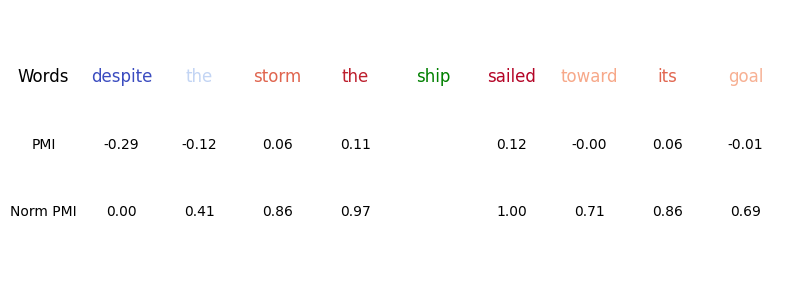

In [18]:
# cosine similarity experiment
make_expermient("Despite the storm the ship sailed toward its goal", 4, 20, model, similarity_function=cosine_similarity_func)

#### Conclusion
> The cosine similarity seems to work well for the ship experiment, as the model provides words that are similar to the masked word, but not the same.

# Conclusions
In this project, we have shown how to explain a generative model using the PMI method. We have also shown how to improve the method by using cosine similarity instead of exact matching. The method has some limitations, but it can still provide useful insights into the model's behavior.